In [1]:
import tensorflow as tf
import keras as K
import myutils 
import pickle
import os
%load_ext autoreload
%reload_ext autoreload
%autoreload 2 


SubjectFlags = [True, False]
MAX_TEXT_LENS = [500]
embedding_size = 50


INPUT_LEN = MAX_TEXT_LENS[0] + 100

tokenizers_path = './tokenizers'
our_path_LSTM = './ourModelsLSTM'
keras_path = './ktModels'
our_path = './ourModels'
             

ModelsNames = ['Balanced', 'UnbalancedReal', 'UnbalancedFake']
ModelsNames = [name+'_'+str(MAX_TEXT_LEN)+'_'+str(subFlag) for name in ModelsNames for subFlag in SubjectFlags for MAX_TEXT_LEN in MAX_TEXT_LENS]

TrainOurModels = {}
TrainKerasModels = {}
TrainLSTMModels = {}

LoadOurModels = {}
LoadKerasModels = {}
LoadLSTMModels = {}

for kind in ModelsNames:
    TrainOurModels[kind] = False
    TrainLSTMModels[kind] = False
    TrainKerasModels[kind] = False
    LoadOurModels[kind] = True
    LoadKerasModels[kind] = True
    LoadLSTMModels[kind] = True
    if not os.path.exists(f'{our_path}/{kind}.h5'):
        TrainOurModels[kind] = True    
        LoadOurModels[kind] = False
    if not os.path.exists(f'{our_path_LSTM}/{kind}.h5'):
        TrainLSTMModels[kind] = True        
        LoadLSTMModels[kind] = False
    if not os.path.exists(f'{keras_path}/{kind}'):
        TrainKerasModels[kind] = True
        LoadLSTMModels[kind] = False

    
# Remove comment if want to train a model from scratch
# TrainKerasModels['Balanced'] = False
TrainLSTMModels['Balanced_500_True'] = False
TrainLSTMModels['UnbalancedReal_500_True'] = False
TrainLSTMModels['UnbalancedFake_500_True'] = False
LoadKerasModels['Balanced_500_True'] = False
LoadKerasModels['UnbalancedReal_500_True'] = False
LoadKerasModels['UnbalancedFake_500_True'] = False


allNews = myutils.initDF()

print(ModelsNames)
# tf.config.list_logical_devices()

Loading data from processed file
['Balanced_500_True', 'Balanced_500_False', 'UnbalancedReal_500_True', 'UnbalancedReal_500_False', 'UnbalancedFake_500_True', 'UnbalancedFake_500_False']



## Create balanced dataset and create train, validation and test sets

In [2]:
from sklearn.model_selection import train_test_split 
# Pop the label column
balancedLabels = allNews.pop('label')

x_train = {}
y_train = {}
x_test = {}
x_val = {}


for kind in ModelsNames:
    if kind.startswith('Balanced'):
        # Split dataset into train, validation and test (it's equal for val and test for each model, only the train is different)
        x_train[kind], x_test[kind], y_train[kind], y_test = train_test_split(allNews.copy(), balancedLabels.copy(), test_size=0.1, train_size=0.9, shuffle=False)
        x_train[kind], x_val[kind], y_train[kind], y_val = train_test_split(x_train[kind].copy(), y_train[kind].copy(), test_size=0.2222, train_size=0.7778, shuffle=False)
        # Check how many samples of each kind we have in the training set
        print(kind, '\n', y_train[kind].value_counts())

Balanced_500_True 
 1    16440
0    14989
Name: label, dtype: int64
Balanced_500_False 
 1    16440
0    14989
Name: label, dtype: int64


## Create unbalanced dataset and create train, validation and test sets
### Only half fake news

In [3]:
# FakeNews label = 1
for kind in ModelsNames:
    typee = '_' + kind.split('_')[1] + '_' + kind.split('_')[2]
    if kind.startswith('UnbalancedFake'):
        x_train[kind], y_train[kind] = myutils.unbalance(x_train['Balanced'+typee].copy(), y_train['Balanced'+typee].copy(), 1, force=True)
        x_val[kind] = x_val['Balanced'+typee].copy()
        print(f"{kind}\n {y_train[kind].value_counts()}")

UnbalancedFake_500_True
 0    14989
1     8220
Name: label, dtype: int64
UnbalancedFake_500_False
 0    14989
1     8220
Name: label, dtype: int64


### Only half real news

In [4]:
# RealNews label = 0
for kind in ModelsNames:
    typee = '_' + kind.split('_')[1] + '_' + kind.split('_')[2]
    if kind.startswith('UnbalancedReal'):
        x_train[kind], y_train[kind] = myutils.unbalance(x_train['Balanced'+typee].copy(), y_train['Balanced'+typee].copy(), 0, force=True)
        x_val[kind] = x_val['Balanced'+typee].copy()
        print(f"{kind}\n {y_train[kind].value_counts()}")

UnbalancedReal_500_True
 1    16440
0     7495
Name: label, dtype: int64
UnbalancedReal_500_False
 1    16440
0     7495
Name: label, dtype: int64


## Dict Index

In [5]:
from keras.preprocessing.text import Tokenizer

vectorizer = {}
vocab_size = {}

for kind in ModelsNames:
    if os.path.exists(f'{tokenizers_path}/{kind}_vectorizer.pickle'):
        with open(f'{tokenizers_path}/{kind}_vectorizer.pickle', 'rb') as handle:
            vectorizer[kind] = pickle.load(handle)
    else:
        # Create a vectorizer for each dataset
        vectorizer[kind] = Tokenizer(num_words=10000)
        
        # Fit the vectorizer to the data in each dataset8
        vectorizer[kind].fit_on_texts(x_train[kind].title)
        vectorizer[kind].fit_on_texts(x_train[kind].text)
        vectorizer[kind].fit_on_texts(x_train[kind].subject)
        
        with open(f'{tokenizers_path}/{kind}_vectorizer.pickle', 'wb') as handle:
            pickle.dump(vectorizer[kind], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save the vocab size for each dataset
    vocab_size[kind] = len(vectorizer[kind].word_index) + 2

### Text conversion

In [6]:

from keras_preprocessing.sequence import pad_sequences

def convert(df, kind, columns = ['title', 'text', 'subject']):
    for column in columns:
        df[column] = vectorizer[kind].texts_to_sequences(df[column])
    return df

# Convert the data in each dataset
for kind in ModelsNames:
    x_train[kind] = convert(x_train[kind].copy(), kind)
    # Convert validation set
    # Validation set is equal for all the tests
    x_val[kind] = convert(x_val[kind].copy(), kind)

In [7]:
for kind in ModelsNames:
    
    print(kind, x_train[kind].shape)

Balanced_500_True (31429, 4)
Balanced_500_False (31429, 4)
UnbalancedReal_500_True (23935, 4)
UnbalancedReal_500_False (23935, 4)
UnbalancedFake_500_True (23209, 4)
UnbalancedFake_500_False (23209, 4)


### Text Padding/Truncation for Normalization

In [8]:
import numpy as np


def Normalize(df, columns = ['title', 'text'], subject = True, MAX_LEN = MAX_TEXT_LENS[0], PaddingKind = 'post'):
    tmp = {}    
    for column in columns:
        tmp[column] = pad_sequences(df[column].tolist(), maxlen=(MAX_LEN if column == 'text' else 100), padding=PaddingKind)
    if subject:
        tmp['subject'] = pad_sequences(df['subject'].tolist(), maxlen=2, padding=PaddingKind)
    out = np.empty((len(tmp['text']), INPUT_LEN + (2 if subject else 0)))
    for i in range(len(tmp['text'])):
        if subject:
            out[i] = np.append(np.append(tmp['text'][i], tmp['title'][i]), tmp['subject'][i])
        else:
            out[i] = np.append(tmp['text'][i], tmp['title'][i])
    return out

for kind in ModelsNames:
    sub = True if kind.split('_')[2] == 'True' else False
    # Read Training Data
    x_train[kind] = Normalize(x_train[kind].copy(),  subject = sub)
    # Convert to numpy arrays the labels for Balanced training dataset
    y_train[kind] = np.array(y_train[kind].copy())
    x_val[kind] = Normalize(x_val[kind].copy(), subject = sub)
    
# Convert to numpy arrays the labels for Validation set
y_val = np.array(y_val)

for kind in ModelsNames:
    out = '' if kind.split('_')[2] != 'True' else 'out'
    # Print shape of data and label for each Training Set
    print('\n')
    print(f'Shape of data and label for {kind} with{out} news argument training set:', x_train[kind].shape, y_train[kind].shape)
    print(f'Shape of data and label for {kind} with{out} news argument Validation set:', x_val[kind].shape, y_val.shape)
    



Shape of data and label for Balanced_500_True without news argument training set: (31429, 602) (31429,)
Shape of data and label for Balanced_500_True without news argument Validation set: (8979, 602) (8979,)


Shape of data and label for Balanced_500_False with news argument training set: (31429, 600) (31429,)
Shape of data and label for Balanced_500_False with news argument Validation set: (8979, 600) (8979,)


Shape of data and label for UnbalancedReal_500_True without news argument training set: (23935, 602) (23935,)
Shape of data and label for UnbalancedReal_500_True without news argument Validation set: (8979, 602) (8979,)


Shape of data and label for UnbalancedReal_500_False with news argument training set: (23935, 600) (23935,)
Shape of data and label for UnbalancedReal_500_False with news argument Validation set: (8979, 600) (8979,)


Shape of data and label for UnbalancedFake_500_True without news argument training set: (23209, 602) (23209,)
Shape of data and label for Unba

## Embedding

In [9]:
import numpy as np
embedding_dict = {}
with open(f"./embeddings/glove.6B.{embedding_size}d.txt") as f:
    for line in f:
        words, coefficients = line.split(maxsplit=1)
        coefficients = np.fromstring(coefficients, "f", sep=" ")
        embedding_dict[words] = coefficients

### Embedding Matrix

In [10]:
import numpy as np
embedding_dim = embedding_size

embedding_matrix = {}

for kind in ModelsNames:
    embedding_matrix[kind] = np.zeros((vocab_size[kind], embedding_dim))
    for word, i in vectorizer[kind].word_index.items():
        embedding_vector = vectorizer[kind].word_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[kind][i] = embedding_vector
    # Print all embedding matrix shapes
    print(kind, embedding_matrix[kind].shape)

Balanced_500_True (126648, 50)
Balanced_500_False (126648, 50)
UnbalancedReal_500_True (112862, 50)
UnbalancedReal_500_False (112911, 50)
UnbalancedFake_500_True (107083, 50)
UnbalancedFake_500_False (107499, 50)


# Tensorflow embedding layer

In [11]:
embedding_layer = {}
for kind in ModelsNames:
    sub = kind.split('_')[2] == 'True'
    embedding_layer[kind] = K.layers.Embedding(vocab_size[kind], 
                                                                embedding_dim, 
                                                                embeddings_initializer= K.initializers.Constant(
                                                                    embedding_matrix[kind]), 
                                                                trainable=False, 
                                                                input_length=INPUT_LEN + (2 if sub else 0))
        
GLOBAL_KIND = 'Balanced'
def getEmbeddingLayer(kind):
    return embedding_layer[kind]

In [12]:
for kind in ModelsNames:
    print(kind, x_train[kind].shape,  y_train[kind].shape)
    print(kind, x_val[kind].shape, y_val.shape)

Balanced_500_True (31429, 602) (31429,)
Balanced_500_True (8979, 602) (8979,)
Balanced_500_False (31429, 600) (31429,)
Balanced_500_False (8979, 600) (8979,)
UnbalancedReal_500_True (23935, 602) (23935,)
UnbalancedReal_500_True (8979, 602) (8979,)
UnbalancedReal_500_False (23935, 600) (23935,)
UnbalancedReal_500_False (8979, 600) (8979,)
UnbalancedFake_500_True (23209, 602) (23209,)
UnbalancedFake_500_True (8979, 602) (8979,)
UnbalancedFake_500_False (23209, 600) (23209,)
UnbalancedFake_500_False (8979, 600) (8979,)


# Tensorflow CNN model

In [13]:
import visualkeras

ourParamModels = {}
ourmodel_hist = {}

for kind in ModelsNames:
    if TrainOurModels[kind]:    
        ourParamModels[kind] = K.Sequential()
        ourParamModels[kind].add(embedding_layer[kind])
        ourParamModels[kind].add(K.layers.Conv1D(128, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Conv1D(64, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Conv1D(32, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Flatten())
        ourParamModels[kind].add(K.layers.Dense(256, activation='relu'))
        ourParamModels[kind].add(K.layers.Dense(1, activation='sigmoid'))
        
        ourParamModels[kind].compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        
        visualkeras.layered_view(ourParamModels[kind], scale_xy=0.8, draw_volume=True, legend=True, to_file=f'{our_path}/images/{kind}.png')
        print(f'Training {kind} model...')
        ourmodel_hist[kind] = ourParamModels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                mode='min',
                                                                                                patience=3,
                                                                                                min_delta=0.003,
                                                                                                restore_best_weights=True)])
        ourmodel_hist[kind] = ourmodel_hist[kind].history
        ourParamModels[kind].save(f'{our_path}/{kind}.h5')
        with open(f'{our_path}/histories/{kind}_hist.hist', 'wb') as file_pi:
            pickle.dump(ourmodel_hist[kind], file_pi)
    else:
        if LoadOurModels[kind]:
            print(f'Loading {kind} model...:')
            if os.path.exists(f'{our_path}/{kind}.h5'):
                ourParamModels[kind] = tf.keras.models.load_model(f'{our_path}/{kind}.h5')
                print(f' {kind} our parameters model loaded')
                if os.path.exists(f'{our_path}/histories/{kind}_hist.hist'):
                    with open(f'{our_path}/histories/{kind}_hist.hist', 'rb') as file_pi:
                        ourmodel_hist[kind] = pickle.load(file_pi)
                    print(f' {kind} our parameters model history loaded')
            else:
                print(f' {kind} our parameters model NOT found')
        else:
            print(f'Not loading {kind} our parameters model as per settings')

Loading Balanced_500_True model...:
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

 Balanced_500_True our parameters model loaded
 Balanced_500_True our parameters model history loaded
Loading Balanced_500_False model...:
 Balanced_500_False our parameters model loaded
 Balanced_500_False our parameters model history loaded
Loading UnbalancedReal_500_True model...:
 UnbalancedReal_500_True our parameters model loaded
 UnbalancedReal_500_True our parameters model history loaded
Loading UnbalancedReal_500_False model...:
 UnbalancedReal_500_False our parameters model loaded
 UnbalancedReal_500_False our parameters model history loaded
Loading UnbalancedFake_500_True model...:
 UnbalancedFake_500_True our parameters model loaded
 UnbalancedFake_500_True our parameters model history loaded
Loading UnbalancedFake_500_False model...:
 UnbalancedFake_500_False our parameters model loaded
 UnbalancedFake_500_False our parameters model history loaded


![Alt text](ourModels/images/UnbalancedFake_500_True.png)

# Keras Tuner for Hyperparameter Tuning (Optional)

In [18]:
import keras_tuner
kerasmodels = {}
kerasmodel_hist = {}

Strides = [1, 2]
Kernels = [3, 4, 5]
Units = [128, 256]

Filters = {}
Filters[0] = [32, 64, 128]
Filters[1] = [32, 64, 128]
Filters[2] = [32, 64, 128]

BatchSizes = [64, 128, 256, 512]
LearningRates = [1e-2, 1e-3, 1e-4, 1e-5]

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        
        kerasmodel = K.Sequential()
        # Embedding Layer
        kerasmodel.add(getEmbeddingLayer(GLOBAL_KIND))
        # First Convolutional Layer
        kerasmodel.add(K.layers.Conv1D(hp.Choice('conv_1_filters', Filters[0]), 
                                hp.Choice('conv_1_kernel', Kernels), 
                                padding='same', activation='relu'))
        kerasmodel.add(K.layers.MaxPooling1D(hp.Choice('conv_1_strides', Strides)))
        # Second Convolutional Layer
        kerasmodel.add(K.layers.Conv1D(hp.Choice('conv_2_filters', Filters[1]), 
                                hp.Choice('conv_2_kernel', Kernels), 
                                padding='same', activation='relu'))
        kerasmodel.add(K.layers.MaxPooling1D(hp.Choice('conv_2_strides', Strides)))
        # Third Convolutional Layer
        kerasmodel.add(K.layers.Conv1D(hp.Choice('conv_3_filters', Filters[2]), 
                                hp.Choice('conv_3_kernel', Kernels), 
                                padding='same', activation='relu'))
        kerasmodel.add(K.layers.MaxPooling1D(hp.Choice('conv_3_strides', Strides)))
        # Flatten Layer
        kerasmodel.add(K.layers.Flatten())
        # Dense Layer
        kerasmodel.add(K.layers.Dense(hp.Choice('dense_1_units', Units), activation='relu'))
        # Classification Layer
        kerasmodel.add(K.layers.Dense(1, activation='sigmoid'))
        
        kerasmodel.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(
                    learning_rate = hp.Choice('learning_rate', LearningRates)
                ), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        return kerasmodel


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
            shuffle=True,
            epochs=15,
            batch_size=hp.Choice("batch_size",  BatchSizes),
            verbose=1,
            workers=-1,
            use_multiprocessing=True
            )

tuner = {}
for kind in ModelsNames:  
    # Finding best hyperparameters for each model
    print("Finding best hyperparameters for ", kind)
    GLOBAL_KIND = kind
    tuner[kind] = keras_tuner.GridSearch(
        MyHyperModel(),
        objective="val_accuracy",
        overwrite=TrainKerasModels[kind],
        directory=f"{keras_path}/{kind}",
        project_name=f"{kind}_CNN",
    )

    # if TrainModels[kind]:
    tuner[kind].search(x_train[kind], y_train[kind], 
                    validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=3,
                            min_delta=0.05,
                            restore_best_weights=True)])
    print(kind, tuner[kind].get_best_hyperparameters()[0].values)
    kerasmodels[kind] = tuner[kind].hypermodel.build(tuner[kind].get_best_hyperparameters()[0])
    if TrainKerasModels[kind]:
        kerasmodel_hist[kind] = kerasmodels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                    epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        mode='min',
        patience=3,
        min_delta=0.05,
        restore_best_weights=True)])
        kerasmodel_hist[kind] = kerasmodel_hist[kind].history
        kerasmodels[kind].save(f'{keras_path}/{kind}.h5')
        with open(f'{keras_path}/histories/{kind}_hist.hist', 'wb') as file_pi:
            pickle.dump(kerasmodel_hist[kind], file_pi)
    else:
        if LoadKerasModels[kind]:
            print(f'Loading {kind} keras model...:')
            if os.path.exists(f'{keras_path}/{kind}.h5'):
                kerasmodels[kind] = tf.keras.models.load_model(f'{keras_path}/{kind}.h5')
                print(f' {kind} keras model loaded')
                if os.path.exists(f'{keras_path}/histories/{kind}_hist.hist'):
                    with open(f'{keras_path}/histories/{kind}_hist.hist', 'rb') as file_pi:
                        kerasmodel_hist[kind] = pickle.load(file_pi)
                    print(f' {kind} keras model history loaded')
            else:
                print(f' {kind} keras model NOT found')
        else:
            kerasmodels.pop(kind)
            print(f'Not loading {kind} keras model as per settings')

Finding best hyperparameters for  Balanced_500_True
INFO:tensorflow:Reloading Tuner from ./ktModels/Balanced_500_True/Balanced_500_True_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit
Balanced_500_True {'conv_1_filters': 32, 'conv_1_kernel': 4, 'conv_1_strides': 2, 'conv_2_filters': 64, 'conv_2_kernel': 4, 'conv_2_strides': 2, 'conv_3_filters': 32, 'conv_3_kernel': 4, 'conv_3_strides': 2, 'dense_1_units': 256, 'learning_rate': 0.001, 'batch_size': 128}
Not loading Balanced_500_True keras model as per settings
Finding best hyperparameters for  Balanced_500_False
INFO:tensorflow:Reloading Tuner from ./ktModels/Balanced_500_False/Balanced_500_False_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit
Balanced_500_False {'conv_1_filters': 128, 'conv_1_kernel': 4, 'conv_1_strides': 2, 'conv_2_filters': 64, 'conv_2_kernel': 4, 'conv_2_strides': 2, 'conv_3_filters': 32, 'conv_3_kernel': 4, 'conv_3_strides': 2, 'dense_1_units': 256, 'learning_rate': 0.001, 'batch_size': 128}
Loading Bal

# Let's try LSTM


In [15]:
import sys
ourParamLSTMModels = {}
ourLSTMModel_hist = {}

for kind in ModelsNames:
    if TrainLSTMModels[kind]:    
        ourParamLSTMModels[kind] = K.Sequential()
        ourParamLSTMModels[kind].add(embedding_layer[kind])
        ourParamLSTMModels[kind].add(K.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)))
        ourParamLSTMModels[kind].add(K.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
        ourParamLSTMModels[kind].add(K.layers.Bidirectional(tf.keras.layers.LSTM(32)))
        ourParamLSTMModels[kind].add(K.layers.Dense(64, activation='relu'))
        ourParamLSTMModels[kind].add(K.layers.Dropout(0.5))
        ourParamLSTMModels[kind].add(K.layers.Dense(1, activation='sigmoid'))
        
        ourParamLSTMModels[kind].compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        
        print(f'Training {kind} model...')
        ourLSTMModel_hist[kind] = ourParamLSTMModels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                mode='min',
                                                                                                patience=3,
                                                                                                min_delta=0.003,
                                                                                                restore_best_weights=True)])
        ourParamLSTMModels[kind] = ourParamLSTMModels[kind].history
        ourParamLSTMModels[kind].save(f'{our_path_LSTM}/{kind}.h5')
        visualkeras.layered_view(ourParamLSTMModels[kind], scale_xy=0.8, draw_volume=True, legend=True, to_file=f'{our_path_LSTM}/images/{kind}.png')
        with open(f'{our_path_LSTM}/histories/{kind}_hist.hist', 'wb') as file_pi:
            pickle.dump(ourmodel_hist[kind], file_pi)
    else:
        if LoadLSTMModels[kind]:
            print(f'Loading {kind} LSTM model...:')
            if os.path.exists(f'{our_path_LSTM}/{kind}.h5'):
                ourParamLSTMModels[kind] = tf.keras.models.load_model(f'{our_path_LSTM}/{kind}.h5')
                print(f' {kind} LSTM model loaded')
                if os.path.exists(f'{our_path_LSTM}/histories/{kind}_hist.hist'):
                    with open(f'{our_path_LSTM}/histories/{kind}_hist.hist', 'rb') as file_pi:
                        ourLSTMModel_hist[kind] = pickle.load(file_pi)
                    print(f' {kind} LSTM model history loaded')
            else:
                print(f' {kind} LSTM model NOT found')
        else:
            print(f'Not loading {kind} LSTM model as per settings')

Not loading Balanced_500_True LSTM model as per settings
Loading Balanced_500_False LSTM model...:
 Balanced_500_False LSTM model loaded
 Balanced_500_False LSTM model history loaded
Not loading UnbalancedReal_500_True LSTM model as per settings
Loading UnbalancedReal_500_False LSTM model...:
 UnbalancedReal_500_False LSTM model loaded
 UnbalancedReal_500_False LSTM model history loaded
Not loading UnbalancedFake_500_True LSTM model as per settings
Loading UnbalancedFake_500_False LSTM model...:
 UnbalancedFake_500_False LSTM model loaded
 UnbalancedFake_500_False LSTM model history loaded


4


IndexError: index 4 is out of bounds for axis 0 with size 4

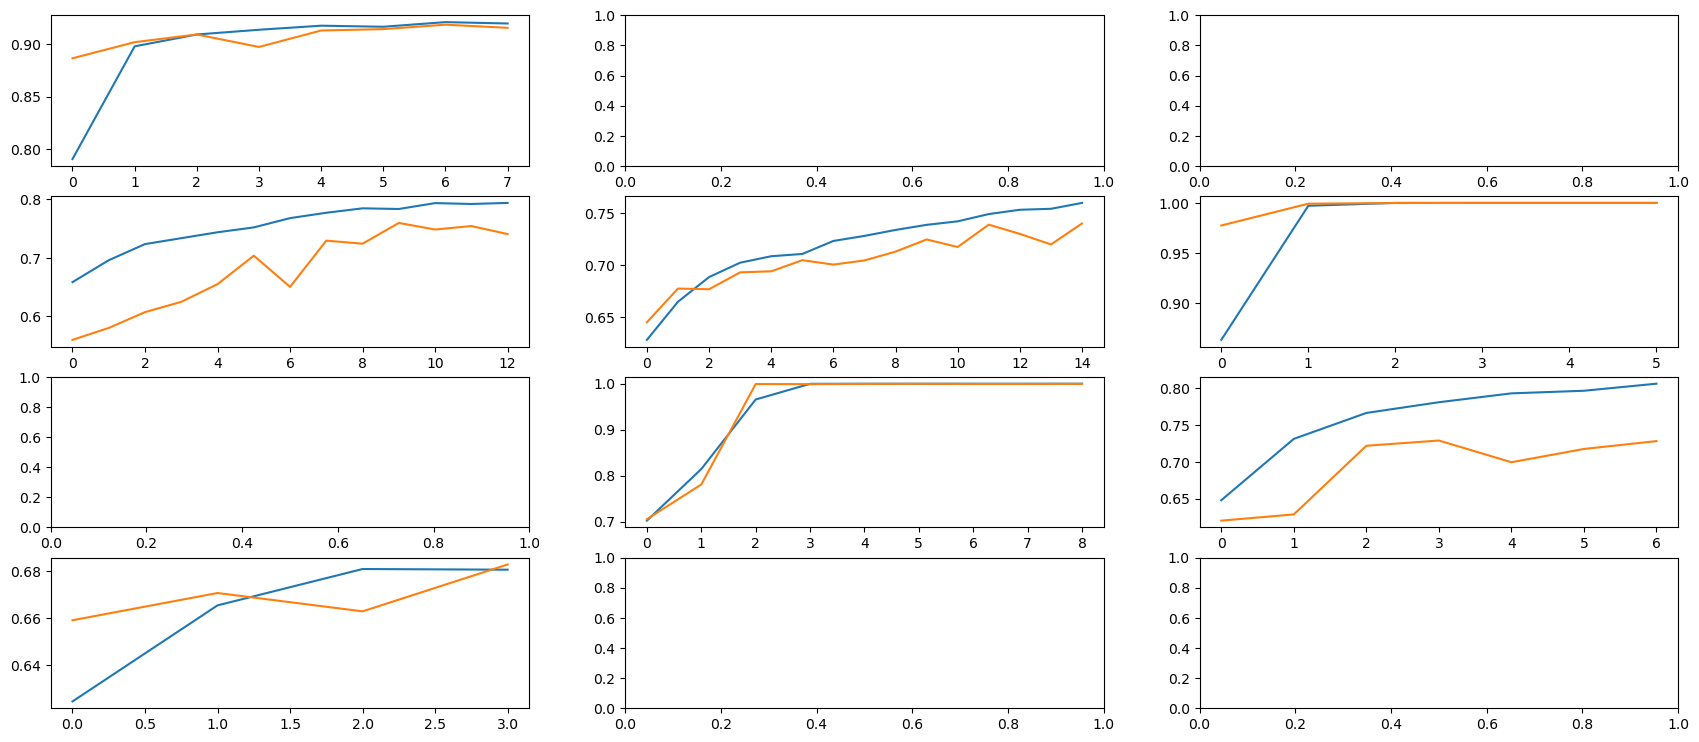

In [49]:
import matplotlib.pyplot as plt

plotstodo = int((len(ourParamLSTMModels.keys()) + len(kerasmodels.keys()) + len(ourParamModels.keys())) / 3)
print(plotstodo)


# Plot a big image to compare the training history of each model, by enanching the best performing one for each kind
fig, ax = plt.subplots(4, 3, figsize=(21, 9))
# ax[0].set_title('Training history')
i = 0
for NN in [ourmodel_hist, kerasmodel_hist, ourLSTMModel_hist]:
    i = 0
    for j, kind in enumerate(NN.keys()):    
        if kind in NN:
            # Plot the accuracy and val_accuracy
            ax[i, j%3].plot(NN[kind]['accuracy'], label=kind + ' accuracy')
            ax[i, j%3].plot(NN[kind]['val_accuracy'], label = kind + ' val_accuracy')
            # Increment i axis if j reached a multiple of 3
            i += 1 if j%3 == 0 else 0

In [17]:
from sklearn import metrics
for kind in ModelsNames:
    # Model 
    print('Our Param: ', kind)
    print('Our Param: Accuracy train set ', kind, metrics.accuracy_score(y_train[kind], ourParamModels[kind].predict(x_train[kind]) >= 0.5 ))
    print('Our Param: Accuracy validation set ', kind, metrics.accuracy_score(y_val, ourParamModels[kind].predict(x_val[kind]) >= 0.5 ))
    print('\n')

Our Param:  Balanced_500_True
 13/983 [..............................] - ETA: 4s  

2023-05-04 10:13:37.030246: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


983/983 [==============================] - 7s 7ms/step
Our Param: Accuracy train set  Balanced_500_True 0.9212192561010532
281/281 [==============================] - 2s 7ms/step
Our Param: Accuracy validation set  Balanced_500_True 0.91324200913242


Our Param:  Balanced_500_False
983/983 [==============================] - 93s 94ms/step
Our Param: Accuracy train set  Balanced_500_False 0.9515415698876833
281/281 [==============================] - 27s 95ms/step
Our Param: Accuracy validation set  Balanced_500_False 0.9469874150796302


Our Param:  UnbalancedReal_500_True
748/748 [==============================] - 5s 7ms/step
Our Param: Accuracy train set  UnbalancedReal_500_True 1.0
281/281 [==============================] - 2s 6ms/step
Our Param: Accuracy validation set  UnbalancedReal_500_True 1.0


Our Param:  UnbalancedReal_500_False
 59/748 [=>............................] - ETA: 1:04

KeyboardInterrupt: 

In [ ]:
import numpy as np
xt = {}
for kind in ModelsNames:
    sub = kind.split('_')[2] == 'True'
    typee = '_' + kind.split('_')[1] + '_' + kind.split('_')[2]
    xt[kind] = convert(x_test['Balanced'+typee].copy(), kind)
    xt[kind] = Normalize(xt[kind], subject=sub)
    xt[kind].shape
y_test = np.array(y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predict = {}
cm = {}
disp = {}
for kind in ModelsNames:
    print(f'Kind {kind} model...')
    test_predict[kind] = (ourParamModels[kind].predict(xt[kind]) >= 0.5).astype('bool')
    cm = confusion_matrix(y_test, test_predict[kind])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

In [ ]:
for kind in ModelsNames:
    print(kind + ' Accuracy test set ', metrics.accuracy_score(y_test, test_predict[kind]))
    print(kind + ' Precision test set ', metrics.precision_score(y_test, test_predict[kind]))
    print(kind + ' Recall test set ', metrics.recall_score(y_test, test_predict[kind]))
    print(kind + ' F1 score test set ', metrics.f1_score(y_test, test_predict[kind]))
    print('\n')